In [1]:
# Making Statistical Significance Against Fritz 
# Figure 9 (as of now) 

In [7]:
# Helper function 
import numpy as np
def closest_index(arr, value):
    arr = np.asarray(arr)
    return np.argmin(np.abs(arr - value))

In [8]:
# The actual 1.15-4.05 values will be exact from the interpolation 
# The uncertainties will be taken from the nearest-wavelength measurement 
# This is within 0.05µm in all cases.

In [9]:
from spisea import reddening 

fritz_law = reddening.RedLawFritz11() 
wavelength, extinction, error = fritz_law._read_Fritz11() 

In [31]:
# Calculating Fritz extinction ratios 

def ratio_and_error(x, σx, y, σy):
    r     = (x / y)[0]
    σr    = (r * np.sqrt((σx / x)**2 + (σy / y)**2))[0]
    return (r, σr)

idx115 = closest_index(wavelength, 1.15) 
idx212 = closest_index(wavelength, 2.12) 
idx323 = closest_index(wavelength, 3.23) 
idx405 = closest_index(wavelength, 4.05) 

A115e = error[idx115]
A212e = error[idx212]
A323e = error[idx323]
A405e = error[idx405]

A115   = fritz_law.Fritz11(wavelength=1.15, A_scale_lambda=2.166)
A212   = fritz_law.Fritz11(wavelength=2.12, A_scale_lambda=2.166) 
A323   = fritz_law.Fritz11(wavelength=3.23, A_scale_lambda=2.166) 
A405   = fritz_law.Fritz11(wavelength=4.05, A_scale_lambda=2.166) 

fritz_ratios = {
    "AF115W/AF212N": ratio_and_error(A115, A115e, A212, A212e),
    "AF323N/AF212N": ratio_and_error(A323, A323e, A212, A212e),
    "AF405N/AF212N": ratio_and_error(A405, A405e, A212, A212e),
}

In [26]:
# Extracting my own extinction ratios 
import pickle, os 
from pathlib import Path 

with open(Path(os.getcwd()) / "raw/ratios.dev", "rb") as f: 
    extinction_ratios = pickle.load(f)

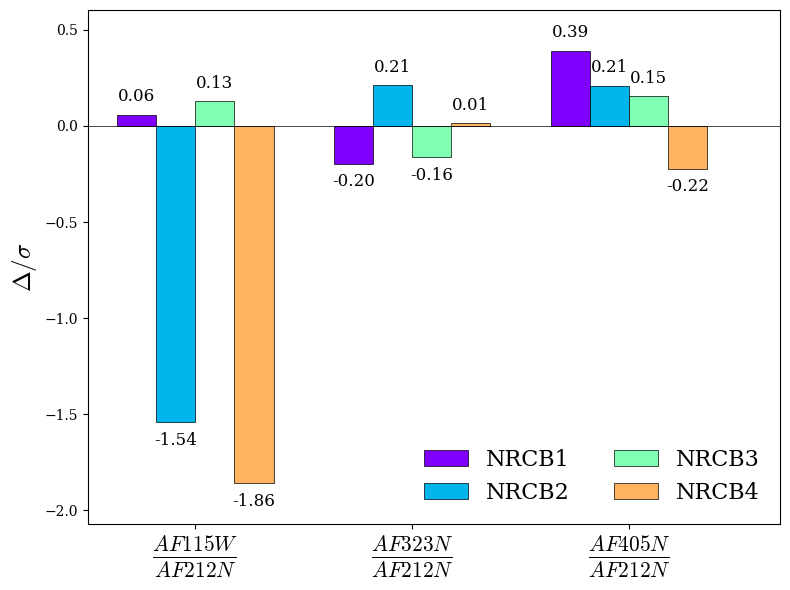

In [41]:
import matplotlib.pyplot as plt 
from cycler import cycler 

plt.rcParams['font.family']      = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm' 

nice5 = plt.get_cmap("rainbow")(np.linspace(0, 1, 5))
plt.rcParams["axes.prop_cycle"] = cycler(color=nice5) 

regions = list(extinction_ratios.keys()) 
ratios  = list(fritz_ratios.keys())
x = np.arange(len(ratios)) 
width = 0.18 


figure, axis = plt.subplots(1, 1, figsize=(8, 6))

for i, region in enumerate(regions):
    sigmas = []
    for band in ratios:
        meas, meas_err = extinction_ratios[region][band]
        ref, ref_err = fritz_ratios[band]
        total_err = np.hypot(meas_err, ref_err)
        sigmas.append((meas - ref) / total_err)
    bars = axis.bar(
        x + (i - (len(regions)-1)/2) * width,
        sigmas,
        width,
        label=region,
        edgecolor='k',
        linewidth=0.5
    )

    # annotate each bar with its Δ/σ
    for bar, sigma in zip(bars, sigmas):
        h = bar.get_height()
        sign = np.sign(h) if h != 0 else 1
        y = h + 0.05 * sign
        va = 'bottom' if sign > 0 else 'top'
        axis.text(
            bar.get_x() + bar.get_width()/2,
            y,
            f"{sigma:.2f}",
            ha='center',
            va=va,
            fontsize=12
        )

axis.axhline(0, color='k', lw=0.5)
axis.set_xlim(min(axis.get_xlim()), max(axis.get_xlim()) + 0.2)
axis.set_ylim(min(axis.get_ylim())-0.1, max(axis.get_ylim())+0.1)
axis.set_xticks(x)
axis.set_xticklabels(
    [r'$\frac{AF115W}{AF212N}$',
     r'$\frac{AF323N}{AF212N}$',
     r'$\frac{AF405N}{AF212N}$'],
    fontsize=22
)
axis.set_ylabel(r'$\Delta/\sigma$', fontsize=18)
axis.legend(ncol=2, fontsize=16, frameon=False, loc="lower right")
plt.tight_layout()